In [98]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [826]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from numpy import array
import math
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import keras 


config = tf.compat.v1.ConfigProto(device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.compat.v1.Session(config=config) 
keras.backend.set_session(sess)
import seaborn as sns

In [827]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [828]:
data = pd.read_csv("in1.csv", header=None)
data.columns = ["lat","long","DNS","DNC","HRS","HRC","RZ-12","DST","F10.7","TEC"]

In [829]:
# Sorting station
station = data['lat'].unique()
data_fs = data.loc[data['lat'] == station[0]]
#data cleaning
# data_fs = data_fs.loc[data['DNS'] != 0.30878]
data_fy = data_fs[['TEC','HRS']]

In [830]:
#คำนวนหา outliers ด้วยวิธี IQR
q3 = data_fs['TEC'].quantile(.75)
q1 = data_fs['TEC'].quantile(.25)
iqr = q3-q1
print('Q1: {}' .format(q1))
print('Q3: {}' .format(q3))
print('IQR: {}' .format(iqr))

upper = q3 + (1.5 * iqr)
lower = q1 - (1.5 * iqr)

Q1: 22.0
Q3: 56.1
IQR: 34.1


C:\Users\User\Anaconda3\envs\heart-cuda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='TEC'>

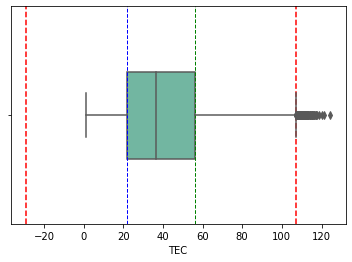

In [831]:
plt.axvline(x=q1, c='b', linestyle='--', linewidth = 1)
plt.axvline(x=q3, c='g', linestyle='--', linewidth = 1)
plt.axvline(x=lower, c='r', linestyle='--')
plt.axvline(x=upper, c='r', linestyle='--')
sns.boxplot(data_fs['TEC'], width=0.4, palette='Set2')

In [832]:

print('Lower {:.2f} \nUpper: {:.2f}' .format(lower,upper))
fil = data_fs['TEC'] > upper
data_fs.drop(data_fs[fil].index, inplace=True)

Lower -29.15 
Upper: 107.25


C:\Users\User\Anaconda3\envs\heart-cuda\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [833]:
def windowed_dataset(series, window_size,
    batch_size, shuffle_buffer):
#     series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1,
    drop_remainder=True)
    dataset = dataset.flat_map(lambda window:
    window.batch(window_size + 1))
    dataset = dataset.map(
    lambda window:
    (window[:-1], window[-1][0]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [834]:
series = np.asarray(data_fy)
time = np.arange(len(data_fy), dtype = "float32")

In [835]:
window_size = 6
batch_size = 128
shuffle_buffer_size = 48

In [836]:
len(series)

27321

In [837]:
split_time = 21856
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:24588]
x_valid = series[split_time:24588]
time_test = time[24588:]
x_test = series[24588:]



In [838]:
dataset = windowed_dataset(x_train, window_size,
        batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size,
        batch_size, shuffle_buffer_size)
test_dataset = windowed_dataset(x_test, window_size, batch_size, shuffle_buffer_size)

In [839]:
# for feature, label in dataset.take(1):
#     print(feature)
#     print(label)

In [840]:
model = tf.keras.models.Sequential([
     tf.keras.layers.LSTM(512, input_shape=[None, 2], return_sequences=True),
    tf.keras.layers.LSTM(512),
     tf.keras.layers.Dense(1)
])

#RNN, LSTM, GRU
optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.3)
model.compile(loss="mse", optimizer=optimizer)

C:\Users\User\Anaconda3\envs\heart-cuda\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [841]:
history = model.fit(dataset, epochs=50, verbose=1,validation_data= valid_dataset)

Epoch 1/50
171/171 [==============================] - 5s 18ms/step - loss: 470.1606 - val_loss: 28.9565
Epoch 2/50
171/171 [==============================] - 2s 14ms/step - loss: 100.6577 - val_loss: 9.5860
Epoch 3/50
171/171 [==============================] - 2s 14ms/step - loss: 47.2332 - val_loss: 8.8017
Epoch 4/50
171/171 [==============================] - 2s 14ms/step - loss: 36.8492 - val_loss: 8.4016
Epoch 5/50
171/171 [==============================] - 2s 14ms/step - loss: 31.9372 - val_loss: 8.1927
Epoch 6/50
171/171 [==============================] - 2s 14ms/step - loss: 29.7721 - val_loss: 7.9882
Epoch 7/50
171/171 [==============================] - 2s 14ms/step - loss: 28.2445 - val_loss: 7.7869
Epoch 8/50
171/171 [==============================] - 3s 17ms/step - loss: 27.1403 - val_loss: 7.6412
Epoch 9/50
171/171 [==============================] - 3s 18ms/step - loss: 26.2826 - val_loss: 7.5000
Epoch 10/50
171/171 [==============================] - 3s 16ms/step - loss: 25.

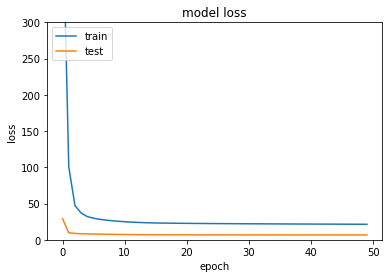

In [842]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')

plt.xlabel('epoch')

plt.ylim([0, 300])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [843]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(128).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [844]:
forecast = model_forecast(model, series, window_size)
results = forecast[24588 - window_size:-1]

Total loss:  12.921347215123799


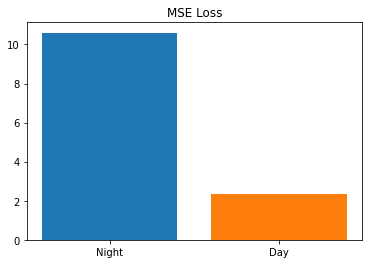

In [845]:
day_loss = []
night_loss = []

day = 115
for i in range(1,day):
    log_valid = x_test[24*(i-1):24*i,0]
    log_pred = results[24*(i-1):24*i,0]
    night_loss.append(tf.keras.losses.mean_squared_error(log_valid[:6],log_pred[:6]).numpy())
    night_loss.append(tf.keras.losses.mean_squared_error(log_valid[18:24], log_pred[18:24]).numpy())
    day_loss.append(tf.keras.losses.mean_absolute_error(log_valid[6:18], log_pred[6:18]).numpy())
night_mse = sum(night_loss)/(day*2)
day_mse = sum(day_loss)/(day)
plt.bar('Night', night_mse)
plt.bar('Day', day_mse)
plt.title('MSE Loss')
print('Total loss: ', (night_mse+day_mse))

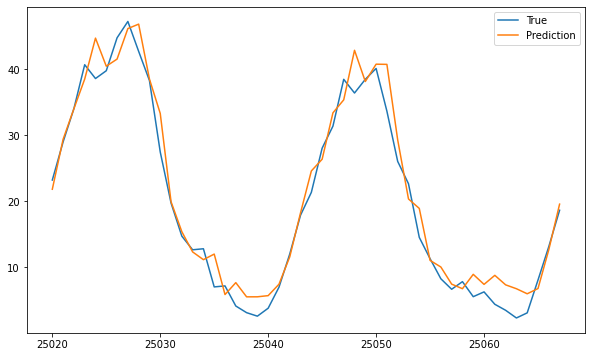

In [850]:
plt.figure(figsize=(10, 6))
i = 10
d = 2
plt.plot(time_test[24*d*(i-1):24*d*i], x_test[24*d*(i-1):24*d*i,0])
plt.plot(time_test[24*d*(i-1):24*d*i], results[24*d*(i-1):24*d*i,0])
plt.legend(['True', "Prediction"])

In [96]:
import keras_tuner 
def build_model(hp):  
    model = tf.keras.models.Sequential([
     tf.keras.layers.LSTM(units=hp.Int('units', min_value=2, max_value=600, step=2), input_shape=[None, 5],
                               return_sequences=True),
     tf.keras.layers.LSTM(units=hp.Int('units2', min_value=2, max_value=600, step=2)),
     tf.keras.layers.Dense(1)
    ])   
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6])  
    momen = hp.Choice('momentum', values=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate, momentum=0.5)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [275]:
tuner = keras_tuner.RandomSearch(build_model, objective='val_loss',
max_trials=60, executions_per_trial=1,
directory='my_dir', project_name='lstm-tune-5_parameters_1119')
tuner.search(dataset, epochs=70, verbose=1, validation_data = valid_dataset)

Trial 28 Complete [00h 03m 29s]
val_loss: 166.2567138671875

Best val_loss So Far: 15.484542846679688
Total elapsed time: 01h 49m 50s

Search: Running Trial #29

Hyperparameter    |Value             |Best Value So Far 
units             |108               |560               
units2            |138               |496               
learning_rate     |1e-06             |1e-05             
momentum          |0.5               |0.3               

Epoch 1/70
274/274 [==============================] - 5s 11ms/step - loss: 2778.2712 - val_loss: 1455.0432
Epoch 2/70
274/274 [==============================] - 3s 10ms/step - loss: 2650.6855 - val_loss: 1365.4910
Epoch 3/70
274/274 [==============================] - 3s 10ms/step - loss: 2518.2200 - val_loss: 1272.6268
Epoch 4/70
274/274 [==============================] - 3s 9ms/step - loss: 2383.2158 - val_loss: 1178.7085
Epoch 5/70
274/274 [==============================] - 3s 10ms/step - loss: 2244.4128 - val_loss: 1080.8633
Epoch 6/70
 19/274

KeyboardInterrupt: 

In [16]:
tuner.results_summary()


Results summary
Results in my_dir\lstm-tune-13_10_11_03
Showing 10 best trials
Objective(name='loss', direction='min')
Trial summary
Hyperparameters:
units: 288
units2: 180
learning_rate: 0.0001
Score: 21.633599599202473
Trial summary
Hyperparameters:
units: 132
units2: 300
learning_rate: 1e-05
Score: 23.25459353129069
Trial summary
Hyperparameters:
units: 190
units2: 276
learning_rate: 1e-06
Score: 27.069854100545246
Trial summary
Hyperparameters:
units: 218
units2: 210
learning_rate: 1e-06
Score: 27.192153930664062
Trial summary
Hyperparameters:
units: 254
units2: 138
learning_rate: 1e-06
Score: 28.307411193847656
Trial summary
Hyperparameters:
units: 176
units2: 88
learning_rate: 0.001
Score: 251.12205505371094


In [293]:
model = tf.keras.models.Sequential([
     tf.keras.layers.LSTM(700, input_shape=[None, 6], return_sequences=True),
     tf.keras.layers.LSTM(500),
     tf.keras.layers.Dense(1)
])

#234, 180, 1
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.3)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=75, verbose=1,validation_data= valid_dataset)

Epoch 1/75
274/274 [==============================] - 6s 14ms/step - loss: 1186.0010 - val_loss: 300.0443
Epoch 2/75
274/274 [==============================] - 3s 12ms/step - loss: 405.8162 - val_loss: 232.3162
Epoch 3/75
274/274 [==============================] - 3s 12ms/step - loss: 245.2375 - val_loss: 199.7195
Epoch 4/75
274/274 [==============================] - 3s 12ms/step - loss: 153.8656 - val_loss: 153.1024
Epoch 5/75
274/274 [==============================] - 3s 12ms/step - loss: 93.6881 - val_loss: 117.1779
Epoch 6/75
274/274 [==============================] - 3s 12ms/step - loss: 65.2296 - val_loss: 91.9844
Epoch 7/75
274/274 [==============================] - 3s 12ms/step - loss: 54.5359 - val_loss: 89.9657
Epoch 8/75
274/274 [==============================] - 3s 12ms/step - loss: 47.8125 - val_loss: 86.7855
Epoch 9/75
274/274 [==============================] - 3s 12ms/step - loss: 44.2705 - val_loss: 82.0224
Epoch 10/75
274/274 [==============================] - 3s 12ms/

KeyboardInterrupt: 